In [1]:
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler, Sampler
from torch.autograd import Variable
from torch.nn.init import xavier_normal, kaiming_normal
import torch.nn.functional as F
import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import random

DATA_DIR = 'Data/'
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [26]:
pickle_train = open(DATA_DIR + "student_train_logs.pickle","rb")
train = pickle.load(pickle_train)

train[9][0].head()

keep_indices = list(set(range(72)) - set([4,11,13,14,15,16,17,18,27,56]))

# In[48]:

validation = {k:v for k, v in random.sample(train.items(), 40)}
train_truncated = { k : train[k] for k in set(train) - set(validation) }

class TrainingSet(Dataset):
    def __init__(self):
        self.idx = list(train_truncated.keys())
        self.sequences = train_truncated
        self.weights = [0.3 if x[2] == 0 else 0.8 for x in self.sequences.values()]
        
    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, id):
        student_id = self.idx[id]
        
        actions = self.sequences[student_id][0].as_matrix().astype(np.float32)
        fixed = self.sequences[student_id][1].as_matrix().astype(np.float32)
        target = np.asarray([self.sequences[student_id][2]]).astype(np.float32)
        fixed_rep = np.repeat(fixed[np.newaxis, ...], actions.shape[0], axis=0)
        seq = np.hstack([fixed_rep, actions])
        return student_id, seq[:,keep_indices], target

class ValidationSet(Dataset):
    def __init__(self):
        self.idx = list(validation.keys())
        self.sequences = validation
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, id):
        student_id = self.idx[id]
        
        actions = self.sequences[student_id][0].as_matrix().astype(np.float32)
        fixed = self.sequences[student_id][1].as_matrix().astype(np.float32)
        target = np.asarray([self.sequences[student_id][2]]).astype(np.float32)
        fixed_rep = np.repeat(fixed[np.newaxis, ...], actions.shape[0], axis=0)
        seq = np.hstack([fixed_rep, actions])
        return student_id, seq[:,keep_indices], target


train_dataset = TrainingSet()
validation_set = ValidationSet()

In [45]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim,
                n_layers, bi):
        super(RNN, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.bi = bi
        self.output_dim = output_dim
        
        self.gru = nn.GRU(input_size=input_dim, hidden_size=hidden_dim,
                         num_layers=n_layers, dropout=0,
                          bidirectional=bi)
        if bi:
            self.decoder = nn.Linear(hidden_dim*2, output_dim)
        else:
            self.decoder = nn.Linear(hidden_dim, output_dim)

        
    def weights_init(self):
        for name, param in self.named_parameters():
            if param.dim() >= 2:
                kaiming_normal(param)


    def init_hidden(self, batch_size):
        if self.bi:
            return Variable(torch.zeros(self.n_layers*2, batch_size, self.hidden_dim)).cuda()
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_dim)).cuda()
    
    
    def forward(self, actions):
        batch_size = actions.size(1)
        hidden_state = self.init_hidden(batch_size)
        out, _ = self.gru(actions, hidden_state)
        out = out[-1,:,:]                                                                                                         
        out = self.decoder(out)                                                                                                   
        out = out.view(batch_size, self.output_dim)                                                                              
        return out
    
    
    def step(self, inp, target):                                                                                                        
        self.zero_grad()                                                                                                           
        output = self.forward(inp)                                                                                                      
        loss = self.criterion(output, target.float())                                                                      
        loss.backward()                                                                                                                 
        self.optimizer.step()
        return loss.data[0], F.sigmoid(output)
    
    
    def predict(self):
        val_targets = []
        val_preds = []
        
        for sid, seq, target in DataLoader(validation_set, batch_size=1, num_workers=8):
            val_targets.append(target.numpy()[0,0])
            
            seq = Variable(seq.permute(1,0,2)).cuda()
            out = F.sigmoid(self.forward(seq))
            
            pred = out.squeeze().cpu().data[0]
            val_preds.append(pred)

        return val_targets, val_preds
    
    def fit(self, train_dataset):
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adamax(self.parameters(), lr=1e-3)
        
        sampler = WeightedRandomSampler(train_dataset.weights, num_samples=len(train_dataset))
        loader = DataLoader(train_dataset, batch_size=1, num_workers=8, sampler=sampler)
        #loader = DataLoader(train_dataset, batch_size=1, num_workers=8, shuffle=True)
        e_losses = []
        e_accs = []
        e_aucs = []
        e_val_accs = []
        e_val_aucs = []
        
        e_bar = tqdm_notebook(range(10), leave=True)
        for e in e_bar:
            self.train()
            e_loss = 0
            preds = []
            targets = []
            for i, (_, seq, label) in enumerate(tqdm_notebook(loader, leave=False)):
                seq = seq.permute(1,0,2)
                loss, output = self.step(Variable(seq).cuda(),
                          Variable(label).cuda())
                e_loss += loss
                preds.append(output.squeeze().cpu().data[0])
                targets.append(label.numpy()[0,0])
            preds = np.array(preds)
            targets = np.array(targets)
            auc = roc_auc_score(targets, preds)
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            
            acc = accuracy_score(preds, targets)
            e_losses.append(e_loss / (i+1))
            e_accs.append(acc)
            e_aucs.append(auc)
            
            y_true, y_preds = model.predict()
            e_val_accs.append(accuracy_score(y_true, [1 if x > 0.5 else 0 for x in y_preds]))
            e_val_aucs.append(roc_auc_score(y_true, y_preds))
            e_bar.set_postfix(acc=acc, e_loss=e_losses[-1], auc=auc, val_acc=e_val_accs[-1], val_auc=e_val_aucs[-1])
            
            
        return e_losses, e_accs, e_aucs, e_val_accs, e_val_aucs

In [47]:
model = RNN(input_dim=len(keep_indices), hidden_dim=256, output_dim=1, n_layers=4, bi=False)
#model.weights_init()
model.cuda()

RNN(
  (gru): GRU(62, 256, num_layers=4)
  (decoder): Linear(in_features=256, out_features=1)
)

In [48]:
e_losses, e_accs, e_aucs, e_val_accs, e_val_aucs = model.fit(train_dataset)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

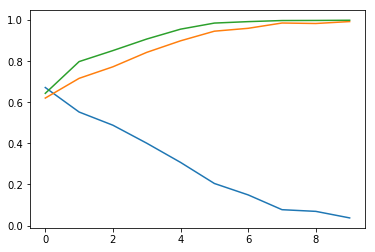

In [38]:
plt.plot(e_losses)
plt.plot(e_accs)
plt.plot(e_aucs)
plt.show()

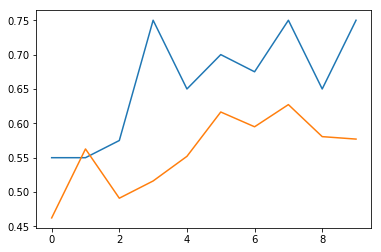

In [39]:
plt.plot(e_val_accs)
plt.plot(e_val_aucs)
plt.show()

In [42]:
y_true, y_preds = model.predict()
for i in range(len(y_true)):
    print(y_true[i], y_preds[i], sep=' --> ')

0.0 --> 0.0009583489154465497
0.0 --> 0.0016256804810836911
0.0 --> 0.003625566139817238
0.0 --> 0.0009572419221512973
0.0 --> 0.3495313227176666
0.0 --> 0.0021771041210740805
1.0 --> 0.030760562047362328
0.0 --> 0.00934471096843481
1.0 --> 0.41292908787727356
0.0 --> 0.019939664751291275
1.0 --> 0.024305054917931557
0.0 --> 0.0156480111181736
1.0 --> 0.10565850138664246
0.0 --> 0.9042503237724304
0.0 --> 0.34456202387809753
0.0 --> 0.04983443021774292
0.0 --> 0.040229398757219315
0.0 --> 0.000972038134932518
0.0 --> 0.00930206011980772
0.0 --> 0.0005747957620769739
0.0 --> 0.14207826554775238
1.0 --> 0.001819773344323039
0.0 --> 0.0030417500529438257
0.0 --> 0.0011276127770543098
0.0 --> 0.03266138955950737
0.0 --> 0.005339385475963354
1.0 --> 0.0016926948446780443
1.0 --> 0.000923766172491014
0.0 --> 0.059649672359228134
1.0 --> 0.0015776694053784013
0.0 --> 0.001106748473830521
1.0 --> 0.6984021067619324
0.0 --> 0.6438707709312439
0.0 --> 0.00044519465882331133
0.0 --> 0.00110309862